In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from neuro_data.static_images import data_schemas
from staticnet_experiments import models as static_models
from staticnet_analyses import base, zd_base
from staticnet_invariance import active_learning, diverse_meis as diverse
from staticnet_invariance.active_learning import best_model
from neuro_data import logger as log
from neuro_data.static_images import stats as neuro_stats
from staticnet_invariance.active_learning import * 
import scipy
from neuro_data.utils.measures import corr
import itertools

imagenet = dj.create_virtual_module('pipeline_imagenet', 'pipeline_imagenet')
stimulus = dj.create_virtual_module('pipeline_stimulus', 'pipeline_stimulus')


Connecting zhiwei@10.28.0.34:3306


/src/static-networks/staticnet_analyses/multi_mei.py:1648: UserWarning: Use of this table is deprecated. It is kept only for record keeping purpose
  warnings.warn('Use of this table is deprecated. It is kept only for record keeping purpose')


In [25]:
TeacherInputResponse.ResponseBlock()

teacher_id,noise_id,clean_responses response to normalized images (images * neurons),noise_responses responses with added noise (images * neurons)
1,1,=BLOB=,=BLOB=
2,1,=BLOB=,=BLOB=


In [227]:
key = (static_models.Model() & 'group_id = 74 and net_hash LIKE "403%%"').fetch('KEY', limit=1)[0]

In [228]:
model = (static_models.Model & key).load_network()
model = model.to('cuda')

13-08-2020:16:21:44 INFO     configs.py           298:	 Ignoring input arguments: "net_hash", "core_hash", "ro_hash", "shift_hash", "mod_hash", "train_hash", "data_hash", "group_id", "seed", "train_type", "schedule", "max_epoch"when creating datasets
13-08-2020:16:21:44 INFO     configs.py           278:	 Loading None dataset with tier=train
13-08-2020:16:21:44 INFO     data_schemas.py     1191:	 Data will be (images,behavior,pupil_center,responses)
13-08-2020:16:21:44 INFO     data_schemas.py     1194:	 Loading dataset group074-22846-10-16-0 --> /external/cache/static22846-10-16-preproc0.h5
13-08-2020:16:21:44 INFO     configs.py           283:	 Adding stats_source "all" to dataset
13-08-2020:16:21:44 INFO     configs.py           286:	 Using statistics source all
13-08-2020:16:21:44 INFO     configs.py           160:	 Excluding "" from normalization
13-08-2020:16:21:44 INFO     configs.py           252:	 Using stimulus.Frame as stimulus type for all datasets
13-08-2020:16:21:44 INFO 

/src/neuro_data/neuro_data/static_images/transforms.py:36: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self._inputs_mean = data.statistics['images/{}/mean'.format(stats_source)].value
/src/neuro_data/neuro_data/static_images/transforms.py:41: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self._inputs_std = data.statistics['images/{}/std'.format(stats_source)].value


In [232]:
im = torch.randn(1, 1, 36, 64).cuda()

In [234]:
model.core(im).shape

torch.Size([1, 96, 22, 50])

In [237]:
model

CorePlusReadout2d(
  (core): GaussianLaplaceCore(
    (_input_weights_regularizer): LaplaceL2(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(15, 15), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace)
      )
      (layer1): Sequential(
        (conv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace)
      )
      (layer2): Sequential(
        (conv): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace)
      )
    )
  ) [GaussianLaplaceCore regularizers: gamma_hidd

In [235]:
from featurevis.ops import Feature_Vector_Ensemble

In [247]:
feavec_f = Feature_Vector_Ensemble([model], 'group074-22846-10-16-0', neuron_idx = [1, 2], device='cuda')

In [248]:
feavec_f(im).shape

torch.Size([1, 576, 2])

In [244]:
576/96

6.0

In [86]:
neurons, avg_corrs = (ToyEnsembleEval.Unit & 'multi_session =1 and train_id = 1').fetch('neuron_id', 'unit_avg_corr', order_by='neuron_id')
top_idxs = np.argsort(avg_corrs)[-500:] # 500 neurons with largest avg_corr
np.random.seed(0)
target_idxs = np.random.choice(top_idxs, 100, replace=False)
target_neurons = neurons[target_idxs]

In [87]:
target_neurons

array([5903,  147, 4741,  660, 4509, 1259, 4603, 1186, 5669, 5458, 1078,
       4108, 4786, 5442, 4218, 3787, 1728, 4048, 4344, 4590, 1318, 4219,
       4491, 4236, 3998, 4202, 4073, 4656, 5953,  103, 4288, 1571, 3673,
       3902, 3408, 1916, 4756,  503, 6032, 5051,  875, 4418, 4373,  668,
       6546, 1591, 1032, 3545, 4675, 4065, 4714,  965, 1079,  404, 4986,
       5193, 4588, 4453,   27, 4848, 5346, 4488, 4915,  368, 4877, 4898,
       4021, 1197, 3335, 1016, 5812, 4448,  262, 3583, 1137, 3398, 4669,
       4624,  129, 3359, 1028, 1478, 4150, 4396, 5094, 4412, 4617, 6421,
       4342, 6456,  111, 4154, 3636, 4367, 4982, 5961,  124, 4486, 5760,
       3987])

In [40]:
all_targets = []
for i in np.arange(20):
    np.random.seed(i)
    target_idxs = np.random.choice(top_idxs, 50, replace=False)
    all_targets.append(target_idxs)

In [47]:
non_target_pool = np.array(list(set(top_idxs) - set(np.unique(np.stack(all_targets).flatten()))))

In [65]:
np.random.seed(0)
chosen_non = np.random.choice(non_target_pool, 19, replace=False)

In [57]:
target_idxs = []
for i in np.arange(20):
    np.random.seed(i)
    idx = np.random.choice(top_idxs, 1, replace=False)
    target_idxs.append(idx.item())

In [58]:
target_neurons = neurons[target_idxs]

In [66]:
non_neurons = neurons[chosen_non]

In [67]:
np.unique(target_neurons).shape

(19,)

In [70]:
np.unique(target_neurons)

array([ 848,  945, 1078, 1079, 1246, 1563, 2090, 2819, 3359, 3837, 4143,
       4150, 4754, 4778, 4844, 4920, 5193, 5903, 6461])

In [71]:
np.unique(non_neurons)

array([ 206,  338,  440,  871, 1288, 1393, 1978, 3392, 3407, 3580, 3640,
       3853, 4160, 4166, 4877, 4895, 5202, 5209, 5346])

In [2]:
neurons = [ 848,  945, 1078, 1079, 1246, 1563, 2090, 2819, 3359, 3837, 4143,
       4150, 4754, 4778, 4844, 4920, 5193, 5903, 6461, 206,  
       338,  440,  871, 1288, 1393, 1978, 3392, 3407, 3580, 3640,
       3853, 4160, 4166, 4877, 4895, 5202, 5209, 5346]

In [3]:
keys1 = (ToyMEI.key_source & 'train_id in (1) and teacher_id = 2 and ensemble_id = 3 and multi_session in (1)' & [{'neuron_id': n} for n in neurons]).fetch('KEY')


In [128]:
deis = (ToyDEIGoodRun & keys1 & 'weight_id > 4').fetch('meis')

### MEI and DEI correaltion (generated from each session's model) for target and non-target cells

In [10]:
ms, train_ids, neuron_ids, meis, mei_acts, deis, distances = (ToyMaskFixedMEI * ToyDEIGoodRun).fetch('multi_session', 'train_id', 'neuron_id', 'mei', 'activation', 'meis', 'avg_negeuclidean', order_by=('multi_session', 'train_id', 'neuron_id'))
                                                                                      

In [32]:
np.array(list(zip(ms, train_ids))).reshape(9, -1, 2)[2]

array([[ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12],
       [ 2, 12

In [8]:
dj.U('multi_session', 'train_id') & ToyMaskFixedMEI()

multi_session,train_id
1,1
2,3
2,12
2,13
2,14
3,3
3,12
3,13
3,14


In [136]:
ToyEnsembleEval & 'multi_session = 2 and train_id > 14'

multi_session,teacher_id,noise_id,ensemble_id,train_id,net_hash unique identifier for configuration,ssid seed set id,n_models number of models that are combined,test_score average testset score,avg_corr correlation of mean neural responses and mean model predictions over repeats
2,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,1,8,0.629454,0.7985
2,2,1,3,16,433595b577c488b6ffbd61e2b999c9e0,1,8,0.634844,0.805394
2,2,1,3,17,433595b577c488b6ffbd61e2b999c9e0,1,8,0.638708,0.810376
2,2,1,3,18,433595b577c488b6ffbd61e2b999c9e0,1,8,0.633166,0.8033
2,2,1,3,19,433595b577c488b6ffbd61e2b999c9e0,1,8,0.635481,0.806314
2,2,1,3,20,433595b577c488b6ffbd61e2b999c9e0,1,8,0.632384,0.802254
2,2,1,3,21,433595b577c488b6ffbd61e2b999c9e0,1,8,0.632547,0.802488
2,2,1,3,22,433595b577c488b6ffbd61e2b999c9e0,1,8,0.635692,0.806517
2,2,1,3,23,433595b577c488b6ffbd61e2b999c9e0,1,8,0.633931,0.80424
2,2,1,3,24,433595b577c488b6ffbd61e2b999c9e0,1,8,0.633764,0.804101


In [57]:
StudentEnsembleModels & 'multi_session = 3 and train_id >14'

multi_session,teacher_id,noise_id,ensemble_id,train_id,net_hash unique identifier for configuration,seed random seed,val_corr validation correlation,model stored model,neurons number of neurons,pearson average test correlation on single trial responses
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,102,0.630314,=BLOB=,2044,0.618823
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,103,0.635212,=BLOB=,2044,0.621698
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,104,0.635984,=BLOB=,2044,0.622858
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,105,0.632517,=BLOB=,2044,0.620361
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,106,0.629671,=BLOB=,2044,0.61657
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,2606,0.624516,=BLOB=,2044,0.612354
3,2,1,3,15,433595b577c488b6ffbd61e2b999c9e0,99999,0.630942,=BLOB=,2044,0.617902
3,2,1,3,16,433595b577c488b6ffbd61e2b999c9e0,101,0.626219,=BLOB=,2044,0.616551
3,2,1,3,16,433595b577c488b6ffbd61e2b999c9e0,102,0.626096,=BLOB=,2044,0.613635
3,2,1,3,16,433595b577c488b6ffbd61e2b999c9e0,103,0.638366,=BLOB=,2044,0.626813


In [17]:
active_learning.schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__student_ensemble_models,6a589186fbd2d3d1fde0f3662b9b82f2,reserved,=BLOB=,,=BLOB=,zhiwei@10.21.17.114,gil-desktop,1,64456,2020-08-11 20:25:43


In [36]:
(active_learning.schema.jobs & 'status = "error"').delete()

### MEI and DEI correaltion (generated from initial session student model) for target and non-target cells

In [4]:
neuron_ids, meis, mei_acts, deis, distances = (ToyMaskFixedMEI * ToyDEIGoodRun & keys1).fetch('neuron_id', 'mei', 'activation', 'meis', 'avg_negeuclidean', order_by='neuron_id')
                                                                                      

In [5]:
batch = np.concatenate([np.stack(meis).reshape(-1, 1, 36, 64), np.stack(deis)], axis=1)

In [6]:
batch = np.transpose(batch, (1, 0, 2, 3))

In [7]:
images = list(itertools.chain(*zip(*batch))) # a list of (mei, dei1, dei2) for 38 neurons


In [8]:
def get_teacher_resps(images, neurons, teacher_id=2, repeats=30):
    key = (TeacherAssignment & {'teacher_id': teacher_id}).fetch1()

    model = [(static_models.Model & key).load_network()]
    mean_eyepos = ([0, 0] if (Dataset.TrainStats & key).fetch1('norm_eyepos') else
                   (Dataset.TrainStats & key).fetch1('mean_eyepos'))
    mean_eyepos = torch.tensor(mean_eyepos, dtype=torch.float32,
                               device='cuda').unsqueeze(0)

    neuron_idx = (base.UnitRanking.Unit & {'group_id':key['group_id'], 'net_hash':key['net_hash'], 'data_hash': key['data_hash']} & [{'neuron_id': n} for n in neurons]).fetch('neuron_id', order_by='neuron_id')
    
    model = models.Ensemble(model, key['readout_key'], eye_pos=mean_eyepos,
                                neuron_idx=neuron_idx, average_batch=False, device='cuda')

    image_tensors = torch.as_tensor(np.stack(images)[:, None], device='cuda')

    with torch.no_grad():
        resps = model(image_tensors).cpu().numpy().squeeze() # images * neurons
    
    # add noise to clean responses 
    noisy_resps = []
    np.random.seed(0)
    for i in range(repeats):
        noisy_resps.append(np.random.normal(resps, resps/3, size=None).clip(min=0))
    noisy_resps = np.stack(noisy_resps)
    mean_noisy_resps = np.mean(noisy_resps, 0)
    
    return resps, noisy_resps, mean_noisy_resps

In [9]:
def get_student_resps(images, neurons, train_id, multi_session, teacher_id=2, noise_id=1, ensemble_id=3):
    # Get idx for each neuron_id
    neuron_idx = (TeacherInputResponse.Unit & {'teacher_id': teacher_id} & [{'neuron_id': n} for n in neurons]).fetch('col_id', order_by='neuron_id')
    
    model_key = {'multi_session': multi_session, 'train_id': train_id, 'teacher_id': teacher_id, 'ensemble_id': ensemble_id, 'noise_id': noise_id}
    all_keys = (StudentEnsembleModels & model_key).fetch('KEY')
    all_models = [(StudentEnsembleModels & mk).load_network() for mk in all_keys]
    readout_key = (MultiSessionDataset & model_key).fetch1('name')
    model = models.Ensemble(all_models, readout_key, neuron_idx=neuron_idx, device='cuda', average_batch=False)
    
    image_tensors = torch.as_tensor(np.stack(images)[:, None], device='cuda')
    with torch.no_grad():
        resps = model(image_tensors).cpu().numpy().squeeze() # images * neurons
        
    return resps

In [10]:
clean_resps, teacher_resps, mean_teacher_resps = get_teacher_resps(images, neuron_ids)

12-08-2020:05:05:17 INFO     configs.py           298:	 Ignoring input arguments: "net_hash", "core_hash", "ro_hash", "shift_hash", "mod_hash", "train_hash", "data_hash", "group_id", "seed", "train_type", "schedule", "max_epoch"when creating datasets
12-08-2020:05:05:17 INFO     configs.py           278:	 Loading None dataset with tier=train
12-08-2020:05:05:17 INFO     data_schemas.py     1191:	 Data will be (images,behavior,pupil_center,responses)
12-08-2020:05:05:17 INFO     data_schemas.py     1194:	 Loading dataset group106-23555-5-12-0 --> /external/cache/static23555-5-12-preproc0.h5
12-08-2020:05:05:17 INFO     configs.py           283:	 Adding stats_source "all" to dataset
12-08-2020:05:05:17 INFO     configs.py           286:	 Using statistics source all
12-08-2020:05:05:17 INFO     configs.py           160:	 Excluding "" from normalization
12-08-2020:05:05:17 INFO     configs.py           252:	 Using stimulus.Frame as stimulus type for all datasets
12-08-2020:05:05:17 INFO   

/src/neuro_data/neuro_data/static_images/transforms.py:36: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self._inputs_mean = data.statistics['images/{}/mean'.format(stats_source)].value
/src/neuro_data/neuro_data/static_images/transforms.py:41: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self._inputs_std = data.statistics['images/{}/std'.format(stats_source)].value


12-08-2020:05:05:18 INFO     readouts.py          145:	 Ignoring input {'ro_hash': '5c0c374cb9a0edef3987e58620830df8'} when creating ModifiedSpatialTransformerPyramid2dReadout
12-08-2020:05:05:18 INFO     shifters.py           55:	 Ignoring input {'shift_hash': '05c69a4aeaeea5e48fa8fc5e70181d67'} when creating MLPShifter
12-08-2020:05:05:18 INFO     shifters.py           27:	 Ignoring input {} when creating MLP
12-08-2020:05:05:18 INFO     modulators.py         47:	 Ignoring input {'mod_hash': 'a757e992ae449e3057ff1d512a51bd1e'} when creating MLPModulator
12-08-2020:05:05:18 INFO     modulators.py         18:	 Ignoring input {} when creating MLP


In [11]:
init_resps = get_student_resps(images, neuron_ids, train_id = 1, multi_session = 1)

12-08-2020:05:05:20 INFO     configs.py           619:	 Ignoring input arguments: "net_hash", "core_hash", "ro_hash", "shift_hash", "mod_hash", "train_hash", "data_hash", "multi_session", "teacher_id", "noise_id", "ensemble_id", "train_id", "seed", "train_type", "schedule", "max_epoch"when creating datasets
12-08-2020:05:05:20 INFO     configs.py           597:	 Loading None dataset with tier=train
12-08-2020:05:05:20 INFO     active_learning.py  1048:	 Fetching data for {'net_hash': '433595b577c488b6ffbd61e2b999c9e0', 'core_hash': '86e5871c1e9112ad5c408697c2ad7d4d', 'ro_hash': 'a206f6da6a16ea14081062a1e2436b48', 'shift_hash': 'bafd7322c6e97d25b6299b5d6fe8920b', 'mod_hash': 'bafd7322c6e97d25b6299b5d6fe8920b', 'train_hash': 'd6c92f34f275b8d2ee52d6b6df257274', 'data_hash': 'b7f468f8e1669aa24bd8fb7216ff59c2', 'multi_session': 1, 'teacher_id': 2, 'noise_id': 1, 'ensemble_id': 3, 'train_id': 1, 'seed': 101, 'data_description': "V1 L2/3 on stimulus.Frame. normalize=False on all (except '')",

In [12]:
import logging
class DisableLogger():
    def __enter__(self):
       logging.disable(logging.WARNING)
    def __exit__(self, a, b, c):
       logging.disable(logging.NOTSET)

In [13]:
from tqdm import tqdm


In [14]:
random_resps, nall_resps, n1_resps, n10_resps, n50_resps, n100_resps = [], [], [], [], [], []

with DisableLogger():
    for s in tqdm([2,3]):
        random_resps.append(get_student_resps(images, neuron_ids, train_id = 3, multi_session = s))
        nall_resps.append(get_student_resps(images, neuron_ids, train_id = 14, multi_session = s))

    for s, t in tqdm(product([2, 3], (TrainParameters & {'n_target_neurons': 1}).fetch('train_id'))):
        n1_resps.append(get_student_resps(images, neuron_ids, train_id = t, multi_session = s))

    for s, t in tqdm(product([2, 3], (TrainParameters & {'n_target_neurons': 10}).fetch('train_id'))):
        n10_resps.append(get_student_resps(images, neuron_ids, train_id = t, multi_session = s))

    for s, t in tqdm(product([2, 3], (TrainParameters & {'n_target_neurons': 50}).fetch('train_id'))):
        n50_resps.append(get_student_resps(images, neuron_ids, train_id = t, multi_session = s))

    for s, t in tqdm(product([2, 3], (TrainParameters & {'n_target_neurons': 100}).fetch('train_id'))):
        n100_resps.append(get_student_resps(images, neuron_ids, train_id = t, multi_session = s))

100%|██████████| 2/2 [00:07<00:00,  3.77s/it]
40it [01:13,  1.83s/it]
40it [01:12,  1.81s/it]
40it [01:13,  1.83s/it]
40it [01:13,  1.84s/it]


In [15]:
random_resps = np.stack(random_resps)
nall_resps = np.stack(nall_resps)
n1_resps = np.stack(n1_resps)
n10_resps = np.stack(n10_resps)
n50_resps = np.stack(n50_resps)
n100_resps = np.stack(n100_resps)

In [24]:
from scipy.stats import pearsonr

In [ ]:
# all_nall_mcorr, all_nall_dcorr, all_nall_pe 

In [201]:
nall_resps.shape

(2, 114, 38)

In [171]:
all_tar_mcorr, all_tar_dcorr, all_tar_pe, all_non_mcorr, all_non_dcorr, all_non_pe = [], [], [], [], [], []
all_init_tar_mcorr, all_init_tar_dcorr, all_init_tar_pe, all_init_non_mcorr, all_init_non_dcorr, all_init_non_pe = [], [], [], [], [], []
all_rand_tar_mcorr, all_rand_tar_dcorr, all_rand_tar_pe, all_rand_non_mcorr, all_rand_non_dcorr, all_rand_non_pe = [], [], [], [], [], []
seeds = np.arange(20)

for session in [2, 3]:
        
    for n_target, resps in zip([1, 10, 50, 100], [n1_resps, n10_resps, n50_resps, n100_resps]):
        tar_mcorr, tar_dcorr, tar_pe = [], [], []
        non_mcorr, non_dcorr, non_pe = [], [], []
        rand_tar_mcorr, rand_tar_dcorr, rand_tar_pe = [], [], []
        rand_non_mcorr, rand_non_dcorr, rand_non_pe = [], [], []
        init_tar_mcorr, init_tar_dcorr, init_tar_pe = [], [], []
        init_non_mcorr, init_non_dcorr, init_non_pe = [], [], []

        for seed in seeds: 
            if seed == 0:
                if n_target == 1:
                    targets = np.array([5903])
                elif n_target == 100:
                    targets = np.array([5903,  147, 4741,  660, 4509, 1259, 4603, 1186, 5669, 5458, 1078,
                   4108, 4786, 5442, 4218, 3787, 1728, 4048, 4344, 4590, 1318, 4219,
                   4491, 4236, 3998, 4202, 4073, 4656, 5953,  103, 4288, 1571, 3673,
                   3902, 3408, 1916, 4756,  503, 6032, 5051,  875, 4418, 4373,  668,
                   6546, 1591, 1032, 3545, 4675, 4065, 4714,  965, 1079,  404, 4986,
                   5193, 4588, 4453,   27, 4848, 5346, 4488, 4915,  368, 4877, 4898,
                   4021, 1197, 3335, 1016, 5812, 4448,  262, 3583, 1137, 3398, 4669,
                   4624,  129, 3359, 1028, 1478, 4150, 4396, 5094, 4412, 4617, 6421,
                   4342, 6456,  111, 4154, 3636, 4367, 4982, 5961,  124, 4486, 5760,
                   3987])
            else:
                train_rel = (TrainParameters & {'train_type': 'avg_rank', 'neuron_seed': seed, 'n_target_neurons': n_target})
                targets = (StudentEnsembleSearchedImages & {'multi_session': 1, 'teacher_id': 2, 'ensemble_id': 3, 'noise_id': 1} & train_rel).fetch('target_neuron_ids')[0]
            
            tars = set(targets).intersection(set(neuron_ids))
            nons = set(neuron_ids) - set(targets)
            tar_idx = [np.argwhere(neuron_ids == n).item() for n in tars]
            non_idx = [np.argwhere(neuron_ids == n).item() for n in nons]

            tar_idxs.extend(tar_idx)
            non_idxs.extend(non_idx)
            for idx in tar_idx:
                r = init_resps[:, idx]
                mei_r = r.reshape(-1, 3)[:, 0]
                dei_r = r.reshape(-1, 3)[:, 1:].flatten()
                real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
                real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
                mei_corr = pearsonr(mei_r, real_mei_r)[0]
                dei_corr = pearsonr(dei_r, real_dei_r)[0]
                pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
                init_tar_mcorr.append(mei_corr)
                init_tar_dcorr.append(dei_corr)
                init_tar_pe.append(pe)
                
                r = resps[(session-2)*len(seeds)+seed, :, idx]
                mei_r = r.reshape(-1, 3)[:, 0]
                dei_r = r.reshape(-1, 3)[:, 1:].flatten()
                real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
                real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
                mei_corr = pearsonr(mei_r, real_mei_r)[0]
                dei_corr = pearsonr(dei_r, real_dei_r)[0]
                pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
                tar_mcorr.append(mei_corr)
                tar_dcorr.append(dei_corr)
                tar_pe.append(pe)
                
                r = random_resps[session-2, :, idx]
                mei_r = r.reshape(-1, 3)[:, 0]
                dei_r = r.reshape(-1, 3)[:, 1:].flatten()
                real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
                real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
                mei_corr = pearsonr(mei_r, real_mei_r)[0]
                dei_corr = pearsonr(dei_r, real_dei_r)[0]
                pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
                rand_tar_mcorr.append(mei_corr)
                rand_tar_dcorr.append(dei_corr)
                rand_tar_pe.append(pe)
                
            for idx in non_idx:
                r = init_resps[:, idx]
                mei_r = r.reshape(-1, 3)[:, 0]
                dei_r = r.reshape(-1, 3)[:, 1:].flatten()
                real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
                real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
                mei_corr = pearsonr(mei_r, real_mei_r)[0]
                dei_corr = pearsonr(dei_r, real_dei_r)[0]
                pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
                init_non_mcorr.append(mei_corr)
                init_non_dcorr.append(dei_corr)
                init_non_pe.append(pe)
                
                r = resps[(session-2)*len(seeds)+seed, :, idx]
                mei_r = r.reshape(-1, 3)[:, 0]
                dei_r = r.reshape(-1, 3)[:, 1:].flatten()
                real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
                real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
                mei_corr = pearsonr(mei_r, real_mei_r)[0]
                dei_corr = pearsonr(dei_r, real_dei_r)[0]
                pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
                non_mcorr.append(mei_corr)
                non_dcorr.append(dei_corr)
                non_pe.append(pe)
                
                r = random_resps[session-2, :, idx]
                mei_r = r.reshape(-1, 3)[:, 0]
                dei_r = r.reshape(-1, 3)[:, 1:].flatten()
                real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
                real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
                mei_corr = pearsonr(mei_r, real_mei_r)[0]
                dei_corr = pearsonr(dei_r, real_dei_r)[0]
                pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
                rand_non_mcorr.append(mei_corr)
                rand_non_dcorr.append(dei_corr)
                rand_non_pe.append(pe)

        all_init_tar_mcorr.append(init_tar_mcorr)
        all_init_tar_dcorr.append(init_tar_dcorr)
        all_init_tar_pe.append(init_tar_pe)
        all_init_non_mcorr.append(init_non_mcorr)
        all_init_non_dcorr.append(init_non_dcorr)
        all_init_non_pe.append(init_non_pe)
                
        all_tar_mcorr.append(tar_mcorr)
        all_tar_dcorr.append(tar_dcorr)
        all_tar_pe.append(tar_pe)
        all_non_mcorr.append(non_mcorr)
        all_non_dcorr.append(non_dcorr)
        all_non_pe.append(non_pe)
    
        all_rand_tar_mcorr.append(rand_tar_mcorr)
        all_rand_tar_dcorr.append(rand_tar_dcorr)
        all_rand_tar_pe.append(rand_tar_pe)
        all_rand_non_mcorr.append(rand_non_mcorr)
        all_rand_non_dcorr.append(rand_non_dcorr)
        all_rand_non_pe.append(rand_non_pe)

In [174]:
[len(i) for i in all_tar_dcorr]

[20, 26, 54, 131, 20, 26, 54, 131]

In [176]:
[len(i) for i in all_rand_non_dcorr]

[740, 734, 706, 629, 740, 734, 706, 629]

In [203]:
init_mcorr, init_dcorr, init_pe, rand_mcorr, rand_dcorr, rand_pe, nall_mcorr, nall_dcorr, nall_pe = [], [], [], [], [], [], [], [], []

for idx in range(init_resps.shape[1]):
    r = init_resps[:, idx]
    mei_r = r.reshape(-1, 3)[:, 0]
    dei_r = r.reshape(-1, 3)[:, 1:].flatten()
    real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
    real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
    mei_corr = pearsonr(mei_r, real_mei_r)[0]
    dei_corr = pearsonr(dei_r, real_dei_r)[0]
    pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
    init_mcorr.append(mei_corr)
    init_dcorr.append(dei_corr)
    init_pe.append(pe)
    
    for session in [0, 1]:
        r = random_resps[session, :, idx]
        mei_r = r.reshape(-1, 3)[:, 0]
        dei_r = r.reshape(-1, 3)[:, 1:].flatten()
        real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
        real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
        mei_corr = pearsonr(mei_r, real_mei_r)[0]
        dei_corr = pearsonr(dei_r, real_dei_r)[0]
        pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
        rand_mcorr.append(mei_corr)
        rand_dcorr.append(dei_corr)
        rand_pe.append(pe)
        
        r = nall_resps[session, :, idx]
        mei_r = r.reshape(-1, 3)[:, 0]
        dei_r = r.reshape(-1, 3)[:, 1:].flatten()
        real_mei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 0]
        real_dei_r = mean_teacher_resps[:, idx].reshape(-1, 3)[:, 1:].flatten()
        mei_corr = pearsonr(mei_r, real_mei_r)[0]
        dei_corr = pearsonr(dei_r, real_dei_r)[0]
        pe = np.abs(mean_teacher_resps[idx*3+1, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+1] / r[idx*3]) + np.abs(mean_teacher_resps[idx*3+2, idx] / mean_teacher_resps[idx*3, idx] - r[idx*3+2] / r[idx*3])
        nall_mcorr.append(mei_corr)
        nall_dcorr.append(dei_corr)
        nall_pe.append(pe)

In [218]:
random_mcorr = np.stack([np.array(init_mcorr), np.array(rand_mcorr).reshape(-1, 2)[:, 0], np.array(rand_mcorr).reshape(-1, 2)[:, 1]])
random_dcorr = np.stack([np.array(init_dcorr), np.array(rand_dcorr).reshape(-1, 2)[:, 0], np.array(rand_dcorr).reshape(-1, 2)[:, 1]])
random_pe = np.stack([np.array(init_pe), np.array(rand_pe).reshape(-1, 2)[:, 0], np.array(rand_pe).reshape(-1, 2)[:, 1]])

neuall_mcorr = np.stack([np.array(init_mcorr), np.array(nall_mcorr).reshape(-1, 2)[:, 0], np.array(nall_mcorr).reshape(-1, 2)[:, 1]])
neuall_dcorr = np.stack([np.array(init_dcorr), np.array(nall_dcorr).reshape(-1, 2)[:, 0], np.array(nall_dcorr).reshape(-1, 2)[:, 1]])
neuall_pe = np.stack([np.array(init_pe), np.array(nall_pe).reshape(-1, 2)[:, 0], np.array(nall_pe).reshape(-1, 2)[:, 1]])

In [219]:
random_mcorr.mean(1)

array([0.93459714, 0.94113968, 0.94482636])

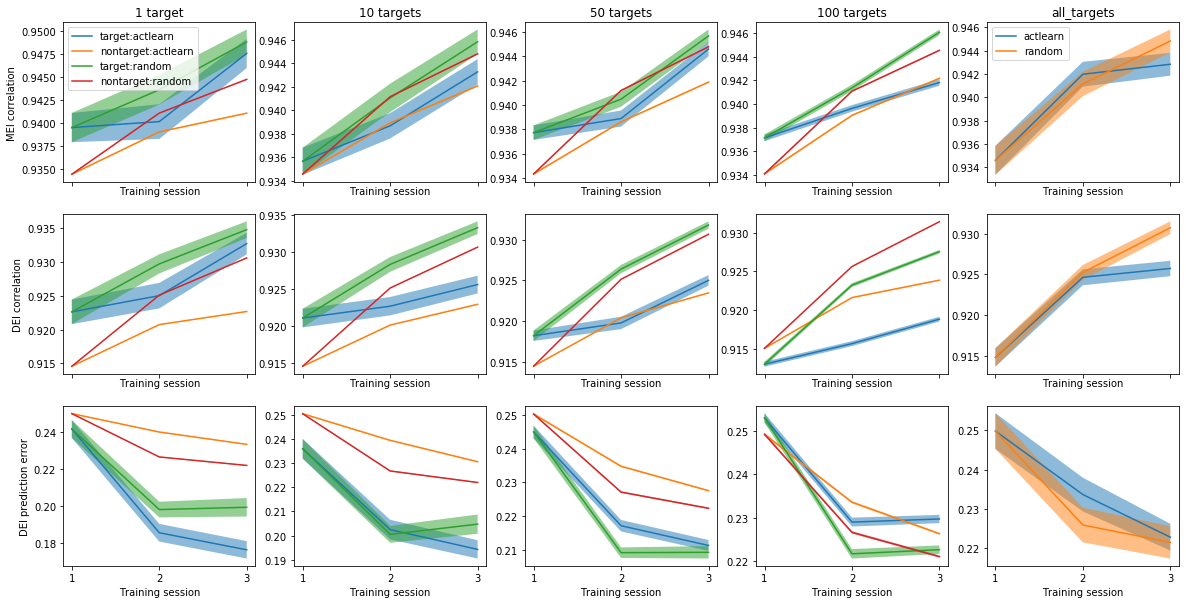

In [222]:
fig, axes = plt.subplots(3, 5, sharex=True, figsize=(20, 10))
sessions = np.arange(1, 4)
n_targets = [1, 5, 10, 100]
labels = ['1 target', '10 targets', '50 targets', '100 targets', 'all_targets']
tar_arrays = [all_tar_mcorr, all_tar_dcorr, all_tar_pe]
non_arrays = [all_non_mcorr, all_non_dcorr, all_non_pe]
rand_tar_arrays = [all_rand_tar_mcorr, all_rand_tar_dcorr, all_rand_tar_pe]
rand_non_arrays = [all_rand_non_mcorr, all_rand_non_dcorr, all_rand_non_pe]
init_tar_arrays = [all_init_tar_mcorr, all_init_tar_dcorr, all_init_tar_pe]
init_non_arrays = [all_init_non_mcorr, all_init_non_dcorr, all_init_non_pe]


for j, (array, init) in enumerate(zip(tar_arrays, init_tar_arrays)):
    m = [np.mean(i) for i in array]
    sem = [np.std(i) / len(i) for i in array]
    init_m = [np.mean(i) for i in init[:4]]
    init_sem = [np.std(i)/len(i) for i in init[:4]]
    for i, ax in enumerate(axes[j][:-1]):
        plot_m = np.array([init_m[i], m[i], m[len(n_targets)+i]])
        plot_sem = np.array([init_sem[i], sem[i], sem[len(n_targets)+i]])
        ax.plot(sessions, plot_m, label='target:actlearn')
        ax.fill_between(sessions, plot_m-plot_sem, plot_m+plot_sem, alpha=0.5)

for j, (array, init) in enumerate(zip(non_arrays, init_non_arrays)):
    m = [np.mean(i) for i in array]
    sem = [np.std(i) / len(i) for i in array]
    init_m = [np.mean(i) for i in init[:4]]
    init_sem = [np.std(i)/len(i) for i in init[:4]]
    for i, ax in enumerate(axes[j][:-1]):
        plot_m = np.array([init_m[i], m[i], m[len(n_targets)+i]])
        plot_sem = np.array([init_sem[i], sem[i], sem[len(n_targets)+i]])
        ax.plot(sessions, plot_m, label='nontarget:actlearn')
        ax.fill_between(sessions, plot_m-plot_sem, plot_m+plot_sem, alpha=0.5)
        
for j, (array, init) in enumerate(zip(rand_tar_arrays, init_tar_arrays)):
    m = [np.mean(i) for i in array]
    sem = [np.std(i) / len(i) for i in array]
    init_m = [np.mean(i) for i in init[:4]]
    init_sem = [np.std(i)/len(i) for i in init[:4]]
    for i, ax in enumerate(axes[j][:-1]):
        plot_m = np.array([init_m[i], m[i], m[len(n_targets)+i]])
        plot_sem = np.array([init_sem[i], sem[i], sem[len(n_targets)+i]])
        ax.plot(sessions, plot_m, label='target:random')
        ax.fill_between(sessions, plot_m-plot_sem, plot_m+plot_sem, alpha=0.5)

for j, (array, init) in enumerate(zip(rand_non_arrays, init_non_arrays)):
    m = [np.mean(i) for i in array]
    sem = [np.std(i) / len(i) for i in array]
    init_m = [np.mean(i) for i in init[:4]]
    init_sem = [np.std(i)/len(i) for i in init[:4]]
    for i, ax in enumerate(axes[j][:-1]):
        plot_m = np.array([init_m[i], m[i], m[len(n_targets)+i]])
        plot_sem = np.array([init_sem[i], sem[i], sem[len(n_targets)+i]])
        ax.plot(sessions, plot_m, label='nontarget:random')
        ax.fill_between(sessions, plot_m-plot_sem, plot_m+plot_sem, alpha=0.5)

m = neuall_mcorr.mean(1)
sem = neuall_mcorr.std(1)/38
axes[0, -1].plot(sessions, m, label='actlearn')
axes[0, -1].fill_between(sessions,m-sem, m+sem, alpha=0.5)
m = random_mcorr.mean(1)
sem = random_mcorr.std(1)/38
axes[0, -1].plot(sessions, m, label='random')
axes[0, -1].fill_between(sessions,m-sem, m+sem, alpha=0.5)

m = neuall_dcorr.mean(1)
sem = neuall_dcorr.std(1)/38
axes[1, -1].plot(sessions, m, label='actlearn')
axes[1, -1].fill_between(sessions,m-sem, m+sem, alpha=0.5)
m = random_dcorr.mean(1)
sem = random_dcorr.std(1)/38
axes[1, -1].plot(sessions, m, label='random')
axes[1, -1].fill_between(sessions,m-sem, m+sem, alpha=0.5)

m = neuall_pe.mean(1)
sem = neuall_pe.std(1)/38
axes[2, -1].plot(sessions, m, label='actlearn')
axes[2, -1].fill_between(sessions,m-sem, m+sem, alpha=0.5)
m = random_pe.mean(1)
sem = random_pe.std(1)/38
axes[2, -1].plot(sessions, m, label='random')
axes[2, -1].fill_between(sessions,m-sem, m+sem, alpha=0.5)

axes[0, 0].legend()
axes[0, -1].legend()

for ax, l in zip(axes[0], labels):
    ax.set_title(l)
axes[0,0].set_ylabel('MEI correlation')
axes[1,0].set_ylabel('DEI correlation')
axes[2,0].set_ylabel('DEI prediction error')

for ax in axes.ravel():
    ax.set_xticks(sessions)
    ax.set_xlabel('Training session')

# for each session, for each train_id, get target neurons and non nontarget ones, aggregate cross train_ids

In [ ]:
for session in [2, 3]:
    for n_target in [1, 10, 50, 100]:
        for seed in seeds: 
            if seed == 0:
                if n_target == 1:
                    targets = np.array([5903])
                elif n_target == 100:
                    targets = np.array([5903,  147, 4741,  660, 4509, 1259, 4603, 1186, 5669, 5458, 1078,
                   4108, 4786, 5442, 4218, 3787, 1728, 4048, 4344, 4590, 1318, 4219,
                   4491, 4236, 3998, 4202, 4073, 4656, 5953,  103, 4288, 1571, 3673,
                   3902, 3408, 1916, 4756,  503, 6032, 5051,  875, 4418, 4373,  668,
                   6546, 1591, 1032, 3545, 4675, 4065, 4714,  965, 1079,  404, 4986,
                   5193, 4588, 4453,   27, 4848, 5346, 4488, 4915,  368, 4877, 4898,
                   4021, 1197, 3335, 1016, 5812, 4448,  262, 3583, 1137, 3398, 4669,
                   4624,  129, 3359, 1028, 1478, 4150, 4396, 5094, 4412, 4617, 6421,
                   4342, 6456,  111, 4154, 3636, 4367, 4982, 5961,  124, 4486, 5760,
                   3987])
            else:
                train_rel = (TrainParameters & {'train_type': 'avg_rank', 'neuron_seed': seed, 'n_target_neurons': n_target})
                train_id = train_fel.fetch1('train_id')
                targets = (StudentEnsembleSearchedImages & {'multi_session': 1, 'teacher_id': 2, 'ensemble_id': 3, 'noise_id': 1} & train_rel).fetch('target_neuron_ids')[0]
            
            nids, (ToyEnsembleEval.Unit() & {'multi_session': session, 'train_id': train_id, 'teacher_id': 2, 'ensemble_id': 3, 'noise_id': 1}).fetch('unit_avg_corr')

In [59]:
target_neurons = [848,  945, 1078, 1079, 1246, 1563, 2090, 2819, 3359, 3837, 4143,
       4150, 4754, 4778, 4844, 4920, 5193, 5903, 6461]

In [60]:
non_neurons = [ 206,  338,  440,  871, 1288, 1393, 1978, 3392, 3407, 3580, 3640,
       3853, 4160, 4166, 4877, 4895, 5202, 5209, 5346]